In this notebook, we train the ODESolver model on the SEIR equation:

$$s'=-\gamma si$$
$$e'=\gamma si - \mu e$$
$$i'=\mu e-\alpha i$$
$$r'=\alpha i$$

The parameters we're estimating are: $\gamma, \mu, \alpha$

In [1]:
import os
import torch

try:
    from torchts.nn.models.ode import ODESolver
except:
    os.chdir("../../../")
    from torchts.nn.models.ode import ODESolver

import matplotlib.pyplot as plt

In [2]:
# SEIR equations
dt = 0.01

def s_prime(prev_val, coeffs):
    return - coeffs["g"]*prev_val["s"]*prev_val["i"]

def e_prime(prev_val, coeffs):
    return coeffs["g"]*prev_val["s"]*prev_val["i"] - coeffs["m"]*prev_val["e"]

def i_prime(prev_val, coeffs):
    return coeffs["m"]*prev_val["e"] - coeffs["a"]*prev_val["i"]

def r_prime(prev_val, coeffs):
    return coeffs["a"]*prev_val["i"]

ode = {"s": s_prime, "e": e_prime, "i": i_prime, "r": r_prime}

# Initial conditions [0,0,0]
ode_init = {"s": 0.1, "e": 0.9, "i": 0, "r": 0}

# Constants (Parameters)
ode_coeffs = {"a": 0.1, "g": 0.3, "m": 0.2}


# 4th Order Runge-Kutta - Data Generation for nt = 1000

In [3]:
ode_solver = ODESolver(
    ode=ode,
    init_vars=ode_init,
    init_coeffs=ode_coeffs,
    dt=dt,
    solver="rk4",
    optimizer=torch.optim.SGD,
    optimizer_args={"lr": 0.01}
)

result = ode_solver(1000)

In [4]:
result

tensor([[1.0000e-01, 9.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0000e-01, 8.9820e-01, 1.7973e-03, 8.9910e-07],
        [9.9999e-02, 8.9641e-01, 3.5892e-03, 3.5928e-06],
        ...,
        [3.3031e-02, 1.5079e-01, 4.4694e-01, 3.6924e-01],
        [3.2987e-02, 1.5053e-01, 4.4679e-01, 3.6969e-01],
        [3.2943e-02, 1.5028e-01, 4.4664e-01, 3.7014e-01]],
       grad_fn=<StackBackward>)

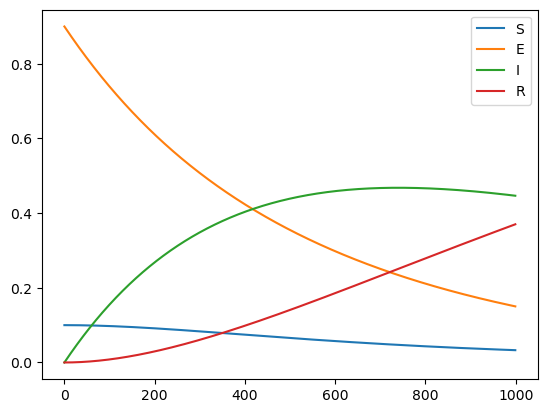

In [5]:
result_np = result.detach().numpy() # Convert to numpy array

# 2D plots
plt.plot(result_np[:,0])
plt.plot(result_np[:,1])
plt.plot(result_np[:,2])
plt.plot(result_np[:,3])

plt.legend(["S", "E", "I", "R"])

plt.show()

# Runge-Kutta method for training

In [6]:
ode_train_coeffs = {"a": torch.rand(()), "g": torch.rand(()), "m": torch.rand(())}

ode_solver_train = ODESolver(
    ode=ode,
    init_vars=ode_init,
    init_coeffs=ode_train_coeffs,
    dt=dt,
    solver="rk4",
    optimizer=torch.optim.Adam,
    optimizer_args={"lr": 0.05},
    scheduler=torch.optim.lr_scheduler.MultiStepLR,
    scheduler_args={"milestones": [5],"gamma": 0.2}
)

/Users/marty/Documents/GitHub/torchTS/torchts/nn/models/ode.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_parameter(name, nn.Parameter(torch.tensor(value)))


In [7]:
ode_solver_train.fit(
    result,
    max_epochs=10,
    batch_size=32
)

Epoch: 0	 Loss: tensor(2.2223e-07, grad_fn=<MseLossBackward>)
{'a': Parameter containing:
tensor(-0.0316, requires_grad=True), 'g': Parameter containing:
tensor(1.8274, requires_grad=True), 'm': Parameter containing:
tensor(0.2801, requires_grad=True)}
Epoch: 1	 Loss: tensor(1.4342e-08, grad_fn=<MseLossBackward>)
{'a': Parameter containing:
tensor(0.1054, requires_grad=True), 'g': Parameter containing:
tensor(1.2495, requires_grad=True), 'm': Parameter containing:
tensor(0.1843, requires_grad=True)}
Epoch: 2	 Loss: tensor(1.9470e-09, grad_fn=<MseLossBackward>)
{'a': Parameter containing:
tensor(0.1108, requires_grad=True), 'g': Parameter containing:
tensor(0.7100, requires_grad=True), 'm': Parameter containing:
tensor(0.2307, requires_grad=True)}
Epoch: 3	 Loss: tensor(4.2590e-10, grad_fn=<MseLossBackward>)
{'a': Parameter containing:
tensor(0.0982, requires_grad=True), 'g': Parameter containing:
tensor(0.4801, requires_grad=True), 'm': Parameter containing:
tensor(0.2006, requires_gra

In [8]:
ode_solver_train.get_coeffs()

{'a': 0.10021188110113144, 'g': 0.3253934681415558, 'm': 0.20081321895122528}

# Predictions for nt = 10000

In [9]:
results_test = ode_solver_train(10000)
results_test

tensor([[1.0000e-01, 9.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0000e-01, 8.9819e-01, 1.8046e-03, 9.0467e-07],
        [9.9999e-02, 8.9639e-01, 3.6038e-03, 3.6150e-06],
        ...,
        [3.9405e-03, 1.4918e-06, 1.1953e-04, 9.9594e-01],
        [3.9405e-03, 1.4903e-06, 1.1942e-04, 9.9594e-01],
        [3.9405e-03, 1.4888e-06, 1.1930e-04, 9.9594e-01]],
       grad_fn=<StackBackward>)

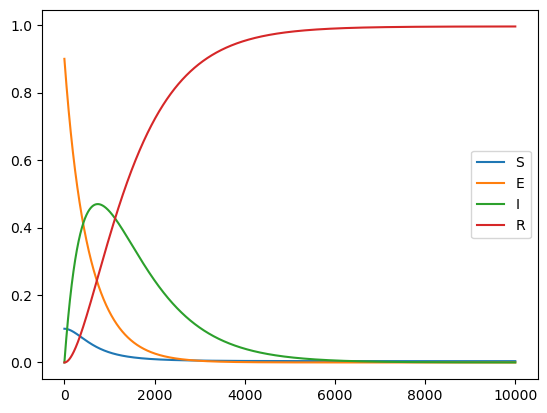

In [10]:
results_test_np = results_test.detach().numpy() # Convert to numpy array

# 2D plots
plt.plot(results_test_np[:,0])
plt.plot(results_test_np[:,1])
plt.plot(results_test_np[:,2])
plt.plot(results_test_np[:,3])

plt.legend(["S", "E", "I", "R"])

plt.show()

# Mean Squared Error Loss - Train set (nt = 1000)

In [11]:
ode_solver = ODESolver(
    ode=ode,
    init_vars=ode_init,
    init_coeffs={"a": 0.1, "g": 0.3, "m": 0.2},
    dt=0.01,
    solver="rk4",
    optimizer=None,
)

In [12]:
loss = torch.nn.MSELoss()
loss(ode_solver(1000),ode_solver_train(1000))

tensor(1.9766e-06, grad_fn=<MseLossBackward>)

# Mean Squared Error Loss - (nt = 2000)

In [13]:
loss = torch.nn.MSELoss()
loss(ode_solver(2000),ode_solver_train(2000))

tensor(2.8463e-06, grad_fn=<MseLossBackward>)